In [2]:
!pip install torch

   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/203.1 MB 393.8 kB/s eta 0:08:36
   ---------------------------------------- 0.1/203.1 MB 363.1 kB/s eta 0:09:20
   ---------------------------------------- 0.1/203.1 MB 438.1 kB/s eta 0:07:44
   ---------------------------------------- 0.2/203.1 MB 573.4 kB/s eta 0:05:54
   ---------------------------------------- 0.2/203.1 MB 728.8 kB/s eta 0:04:39
   ---------------------------------------- 0.3/203.1 MB 874.1 kB/s eta 0:03:52
   ---------------------------------------- 0.4/203.1 MB 955.7 kB/s eta 0:03:33
   ---------------------------------------- 0.5/203.1 MB 1.1 MB/s eta 0:03:13
   ---------------------------------------- 0.5/203.1 MB 1.1 MB/s eta 0:03:02


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\Dell\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dell\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dell\anaconda3\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dell\anaconda3\Lib\http\client.py", line 473, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\Users\Dell\anaconda3\Lib\socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import roc_curve,roc_auc_score
# from utils import *
# from usad import *

## Utils


In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def plot_history(history):
    losses1 = [x['val_loss1'] for x in history]
    losses2 = [x['val_loss2'] for x in history]
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()

def histogram(y_test,y_pred):
    plt.figure(figsize=(12,6))
    plt.hist([y_pred[y_test==0],
              y_pred[y_test==1]],
            bins=20,
            color = ['#82E0AA','#EC7063'],stacked=True)
    plt.title("Results",size=20)
    plt.grid()
    plt.show()

def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

def confusion_matrix(target, predicted, perc=False):

    data = {'y_Actual':    target,
            'y_Predicted': predicted
            }
    df = pd.DataFrame(data, columns=['y_Predicted','y_Actual'])
    confusion_matrix = pd.crosstab(df['y_Predicted'], df['y_Actual'], rownames=['Predicted'], colnames=['Actual'])

    if perc:
        sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Blues')
    else:
        sns.heatmap(confusion_matrix, annot=True, fmt='d')
    plt.show()

## USAD model

In [17]:
# from utils import *
device = get_default_device()

class Encoder(nn.Module):
  def __init__(self, in_size, latent_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, int(in_size/2))
    self.linear2 = nn.Linear(int(in_size/2), int(in_size/4))
    self.linear3 = nn.Linear(int(in_size/4), latent_size)
    self.relu = nn.ReLU(True)

  def forward(self, w):
    out = self.linear1(w)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    z = self.relu(out)
    return z

class Decoder(nn.Module):
  def __init__(self, latent_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(latent_size, int(out_size/4))
    self.linear2 = nn.Linear(int(out_size/4), int(out_size/2))
    self.linear3 = nn.Linear(int(out_size/2), out_size)
    self.relu = nn.ReLU(True)
    self.sigmoid = nn.Sigmoid()

  def forward(self, z):
    out = self.linear1(z)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    w = self.sigmoid(out)
    return w

class UsadModel(nn.Module):
  def __init__(self, w_size, z_size):
    super().__init__()
    self.encoder = Encoder(w_size, z_size)
    self.decoder1 = Decoder(z_size, w_size)
    self.decoder2 = Decoder(z_size, w_size)

  def training_step(self, batch, n):
    z = self.encoder(batch)
    w1 = self.decoder1(z)
    w2 = self.decoder2(z)
    w3 = self.decoder2(self.encoder(w1))
    loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
    loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
    return loss1,loss2

  def validation_step(self, batch, n):
    with torch.no_grad():
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
        loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
    return {'val_loss1': loss1, 'val_loss2': loss2}

  def validation_epoch_end(self, outputs):
    batch_losses1 = [x['val_loss1'] for x in outputs]
    epoch_loss1 = torch.stack(batch_losses1).mean()
    batch_losses2 = [x['val_loss2'] for x in outputs]
    epoch_loss2 = torch.stack(batch_losses2).mean()
    return {'val_loss1': epoch_loss1.item(), 'val_loss2': epoch_loss2.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))

def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
    for epoch in range(epochs):
        print(f'Epoch ', epoch)
        for [batch] in train_loader:
            batch=to_device(batch,device)

            #Train AE1
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss1.backward()
            optimizer1.step()
            optimizer1.zero_grad()


            #Train AE2
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss2.backward()
            optimizer2.step()
            optimizer2.zero_grad()


        result = evaluate(model, val_loader, epoch+1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def testing(model, test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for [batch] in test_loader:
            batch=to_device(batch,device)
            w1=model.decoder1(model.encoder(batch))
            w2=model.decoder2(model.encoder(w1))
            results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

## Normal

In [23]:
normal = pd.read_csv("../Normal.csv")
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
print(normal.shape)

# Transform all columns into float64
for i in list(normal):
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

(496800, 51)


## Attack

In [24]:
attack = pd.read_csv("../Attack.csv")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
print(attack.shape)

# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

x = attack.values
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)
attack.head(2)


(449919, 51)


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.457396,1.0,1.0,0.0,0.62727,0.25853,0.104221,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.457440,1.0,1.0,0.0,0.62727,0.25853,0.104221,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


## Windows

In [28]:
window_size=10

windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
print(windows_normal.shape)

windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
print(windows_attack.shape)

(496788, 12, 51)
(449907, 12, 51)


# Training


In [30]:
import torch.utils.data as data_utils

BATCH_SIZE = 100
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [ ]:
# history = training(N_EPOCHS,model,train_loader,val_loader)
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch  0


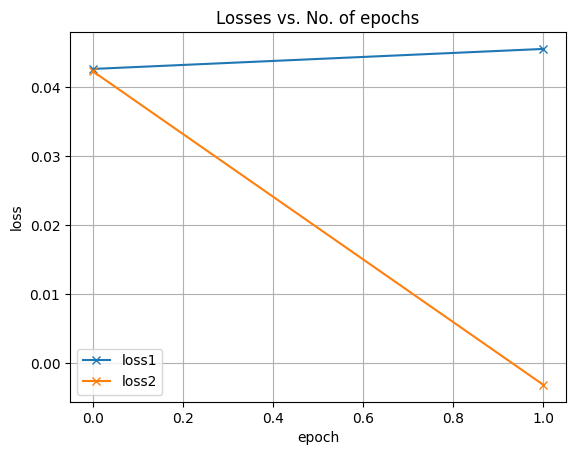

In [ ]:
plot_history(history)


In [ ]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

model.eval()


UsadModel(
  (encoder): Encoder(
    (linear1): Linear(in_features=612, out_features=306, bias=True)
    (linear2): Linear(in_features=306, out_features=153, bias=True)
    (linear3): Linear(in_features=153, out_features=1200, bias=True)
    (relu): ReLU(inplace=True)
  )
  (decoder1): Decoder(
    (linear1): Linear(in_features=1200, out_features=153, bias=True)
    (linear2): Linear(in_features=153, out_features=306, bias=True)
    (linear3): Linear(in_features=306, out_features=612, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  )
  (decoder2): Decoder(
    (linear1): Linear(in_features=1200, out_features=153, bias=True)
    (linear2): Linear(in_features=153, out_features=306, bias=True)
    (linear3): Linear(in_features=306, out_features=612, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  )
)

## Saving to ONNX

In [ ]:
!pip install onnxruntime
!pip install onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 52.0 MB/s eta 0:00:00


In [ ]:
# Ensure the device is set to the same device as the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the same device as the input
model.to(device)

# Generate dummy input on the same device as the model
dummy_input = torch.randn(1, w_size).to(device)  # Adjust w_size as needed

# Export the encoder to ONNX
torch.onnx.export(
    model.encoder,
    dummy_input,
    "usad_encoder.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['latent'],
    dynamic_axes={'input': {0: 'batch_size'}, 'latent': {0: 'batch_size'}}
)

# Export the encoder to ONNX
torch.onnx.export(
    model.decoder1,
    torch.randn(1, 1200).to(device),
    "usad_decoder1.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['latent'],
    dynamic_axes={'input': {0: 'batch_size'}, 'latent': {0: 'batch_size'}}
)

# Export the encoder to ONNX
torch.onnx.export(
    model.decoder2,
    torch.randn(1, 1200).to(device),
    "usad_decoder2.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['latent'],
    dynamic_axes={'input': {0: 'batch_size'}, 'latent': {0: 'batch_size'}}
)


In [ ]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<ipython-input-25-6ed220ec2271>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model.pth")


<All keys matched successfully>

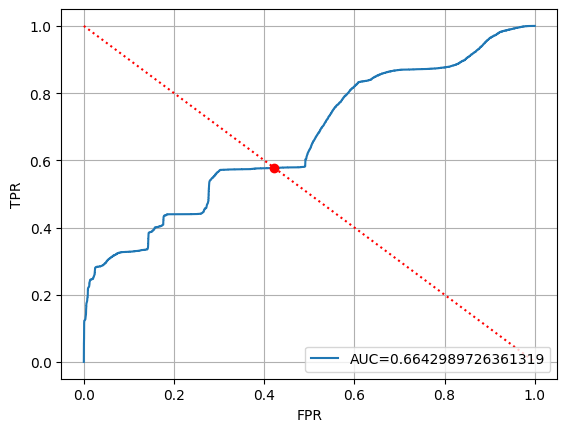

In [ ]:
results=testing(model,test_loader)
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

threshold=ROC(y_test,y_pred)
